# Community Detection with networkx

## 1. load the required packages

In [1]:
import itertools
import operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import networkx as nx
import networkx.algorithms.community as nxcom
from node2vec import Node2Vec
import operator 

D:\anaconda2020\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 2. import dataset and obtain the preprocessed data

### 2.1 dataset for 2020

In [2]:
df = pd.read_excel('../data/all_submission_files.xlsx')
data=df[df["report_end_date"].dt.year==2020]
data.head(n=6)

,report_end_date,cik,nameOfIssuer,titleOfClass,cusip,value,sshPrnamt,sshPrnamtType
0,2020-09-30,1129770,SPDR S&P 500,COM,824348106,70889608000,211680,SH
1,2020-09-30,1129770,SPDR Dow Jones Ind,COM,78467x109,29886300000,107698,SH
2,2020-09-30,1129770,Ishares Russell,COM,464287622,26825894000,143339,SH
3,2020-09-30,1129770,Invesco QQQ TRUST,COM,73935a104,21672909000,78005,SH
4,2020-09-30,1129770,iShares Russell 20,COM,464287655,9434973000,62988,SH
5,2020-09-30,1129770,SPDR S&P Mid-Cap 4,COM,78464a821,9351708000,27600,SH


In [3]:
# for each cik, we just select top 6 shareholdings 
df_top6 = data.sort_values('value',ascending = False).groupby('cik').head(6)

### 3.Graph of the data

In [4]:
# Find all the possible CIK combinations (sorted) of length 2
all_cik_pairs = list(itertools.combinations(df_top6['cik'].unique(), 2))

In [5]:
df_top6[df_top6['cik']==all_cik_pairs[0][0]]

,report_end_date,cik,nameOfIssuer,titleOfClass,cusip,value,sshPrnamt,sshPrnamtType
0,2020-09-30,1129770,SPDR S&P 500,COM,824348106,70889608000,211680,SH
1,2020-09-30,1129770,SPDR Dow Jones Ind,COM,78467x109,29886300000,107698,SH
2,2020-09-30,1129770,Ishares Russell,COM,464287622,26825894000,143339,SH
3,2020-09-30,1129770,Invesco QQQ TRUST,COM,73935a104,21672909000,78005,SH
4,2020-09-30,1129770,iShares Russell 20,COM,464287655,9434973000,62988,SH
5,2020-09-30,1129770,SPDR S&P Mid-Cap 4,COM,78464a821,9351708000,27600,SH


In [6]:
# For each CIK pair, find the number of overlapping cusips
# Creates a list [[cik1, cik2], nr_of_overlapping_cusips]
nodes_and_edges = []
for cik_pair in all_cik_pairs:
    df1 = df_top6[df_top6['cik']==cik_pair[0]]
    df2 = df_top6[df_top6['cik']==cik_pair[1]]
    nr_of_shared_cusips = len(df2[df2["cusip"].isin(df1["cusip"])])
    # add weight for each conbination: the weight = log(sum(cik1.value)+sum(cik2.value))
    if nr_of_shared_cusips == 0:
        weight=0
    else:
        weight = round(np.log(df1['value'].sum()+df2['value'].sum()),2)
    nodes_and_edges.append([cik_pair,weight])

In [7]:
#adjust the weigth for better visulation on the plot: (log2(weight)-mean(log2))*10
weigth_list=[(np.log2(n)-4.3)*10 for c,n in nodes_and_edges if n>0]

In [9]:
df_top6[df_top6['cik']==all_cik_pairs[1][0]]

,report_end_date,cik,nameOfIssuer,titleOfClass,cusip,value,sshPrnamt,sshPrnamtType
0,2020-09-30,1129770,SPDR S&P 500,COM,824348106,70889608000,211680,SH
1,2020-09-30,1129770,SPDR Dow Jones Ind,COM,78467x109,29886300000,107698,SH
2,2020-09-30,1129770,Ishares Russell,COM,464287622,26825894000,143339,SH
3,2020-09-30,1129770,Invesco QQQ TRUST,COM,73935a104,21672909000,78005,SH
4,2020-09-30,1129770,iShares Russell 20,COM,464287655,9434973000,62988,SH
5,2020-09-30,1129770,SPDR S&P Mid-Cap 4,COM,78464a821,9351708000,27600,SH


In [10]:
# The number of nodes that are connected
len([c for c,n in nodes_and_edges if n>0])

1352

In [11]:
# DEBUG ONLY: take only the first 200 edges
# nodes_and_edges = nodes_and_edges[:200]

In [12]:
# Build a network of all CIK's.
# Add an edge between each CIK that invests in overlapping cusips, add weight +1 for each overlapping cusip
G=nx.Graph()
for (cik1, cik2), weight in nodes_and_edges:
    if weight == 0:
        pass
        # Don't add the nodes that are not connected, makes the graph impossible to understand
        # G.add_node(cik1)
        # G.add_node(cik2)
    elif weight > 1:
        # Take a mimimum amount of shared cusips for visibility
        G.add_edge(cik1,cik2,weight=nr_of_shared_cusips)

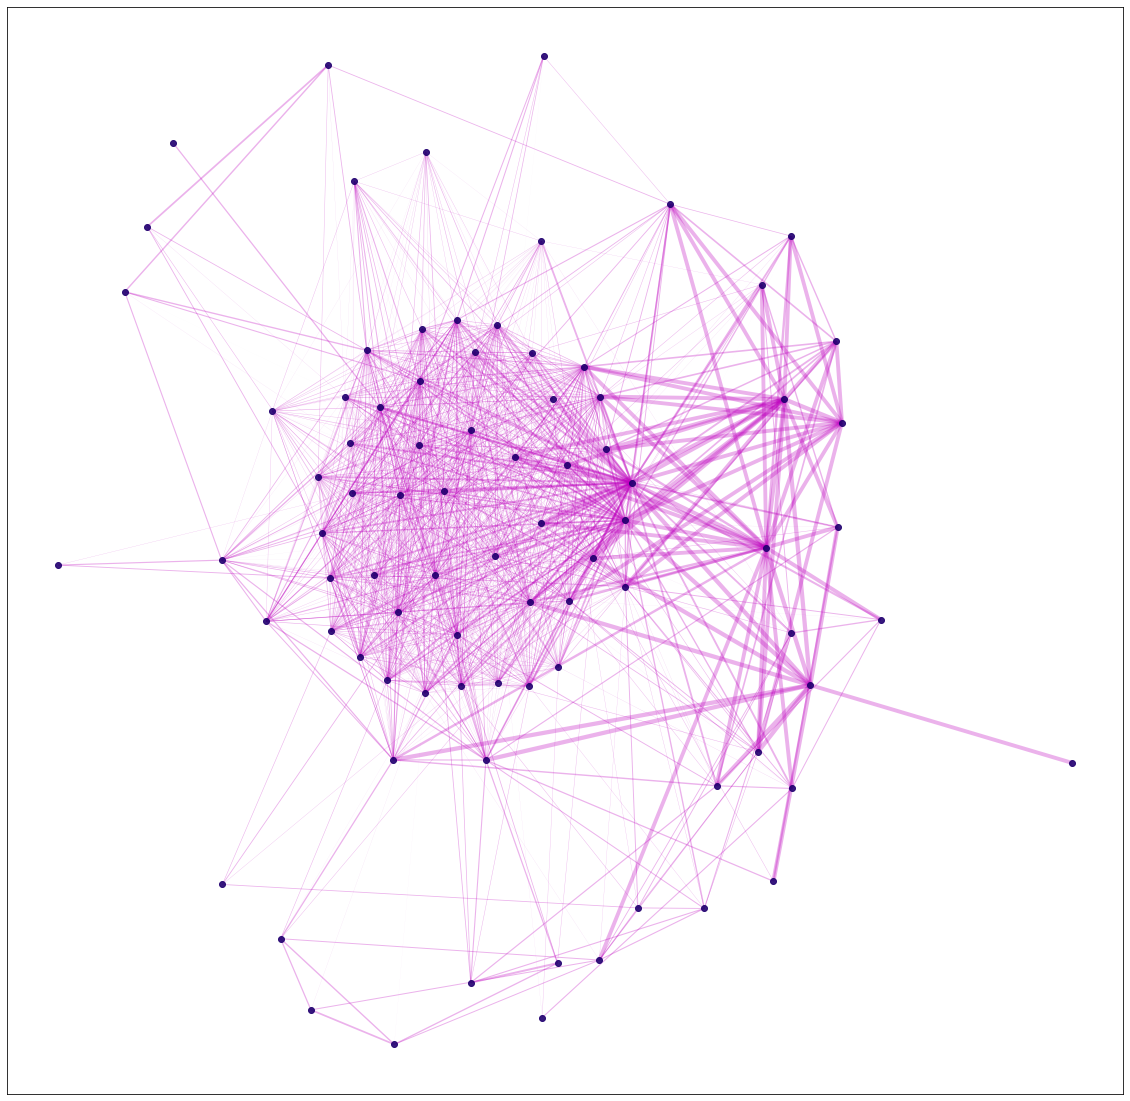

In [22]:
node_size =  None
edge_width = [w for _,w in nodes_and_edges]
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(20,20))
# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.3, width=weigth_list, edge_color="m")
nx.draw_networkx_nodes(G, pos, node_size=None, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
# _ = nx.draw_networkx_labels(G, pos, font_size=14, bbox=label_options)


In [14]:
# Find the communities
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
# Count the communities
print(f"The group of investment funds has {len(communities)} communities.")

The group of investment funds has 4 communities.


# Used this example:
# https://graphsandnetworks.com/community-detection-using-networkx/

In [15]:
# Helper functions to plot the graph with community labels
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [16]:
# Set node and edge communities
set_node_community(G, communities)
set_edge_community(G)

node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

# Set community color for edges between members of the same community (internal) and intra-community edges (external)
#external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
#internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
#internal_color = ['black' for e in internal]

In [36]:
#creat the node degree list for weigth node size
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')
node_degree=[np.log(i)*400 for i in degree_dict.values()]

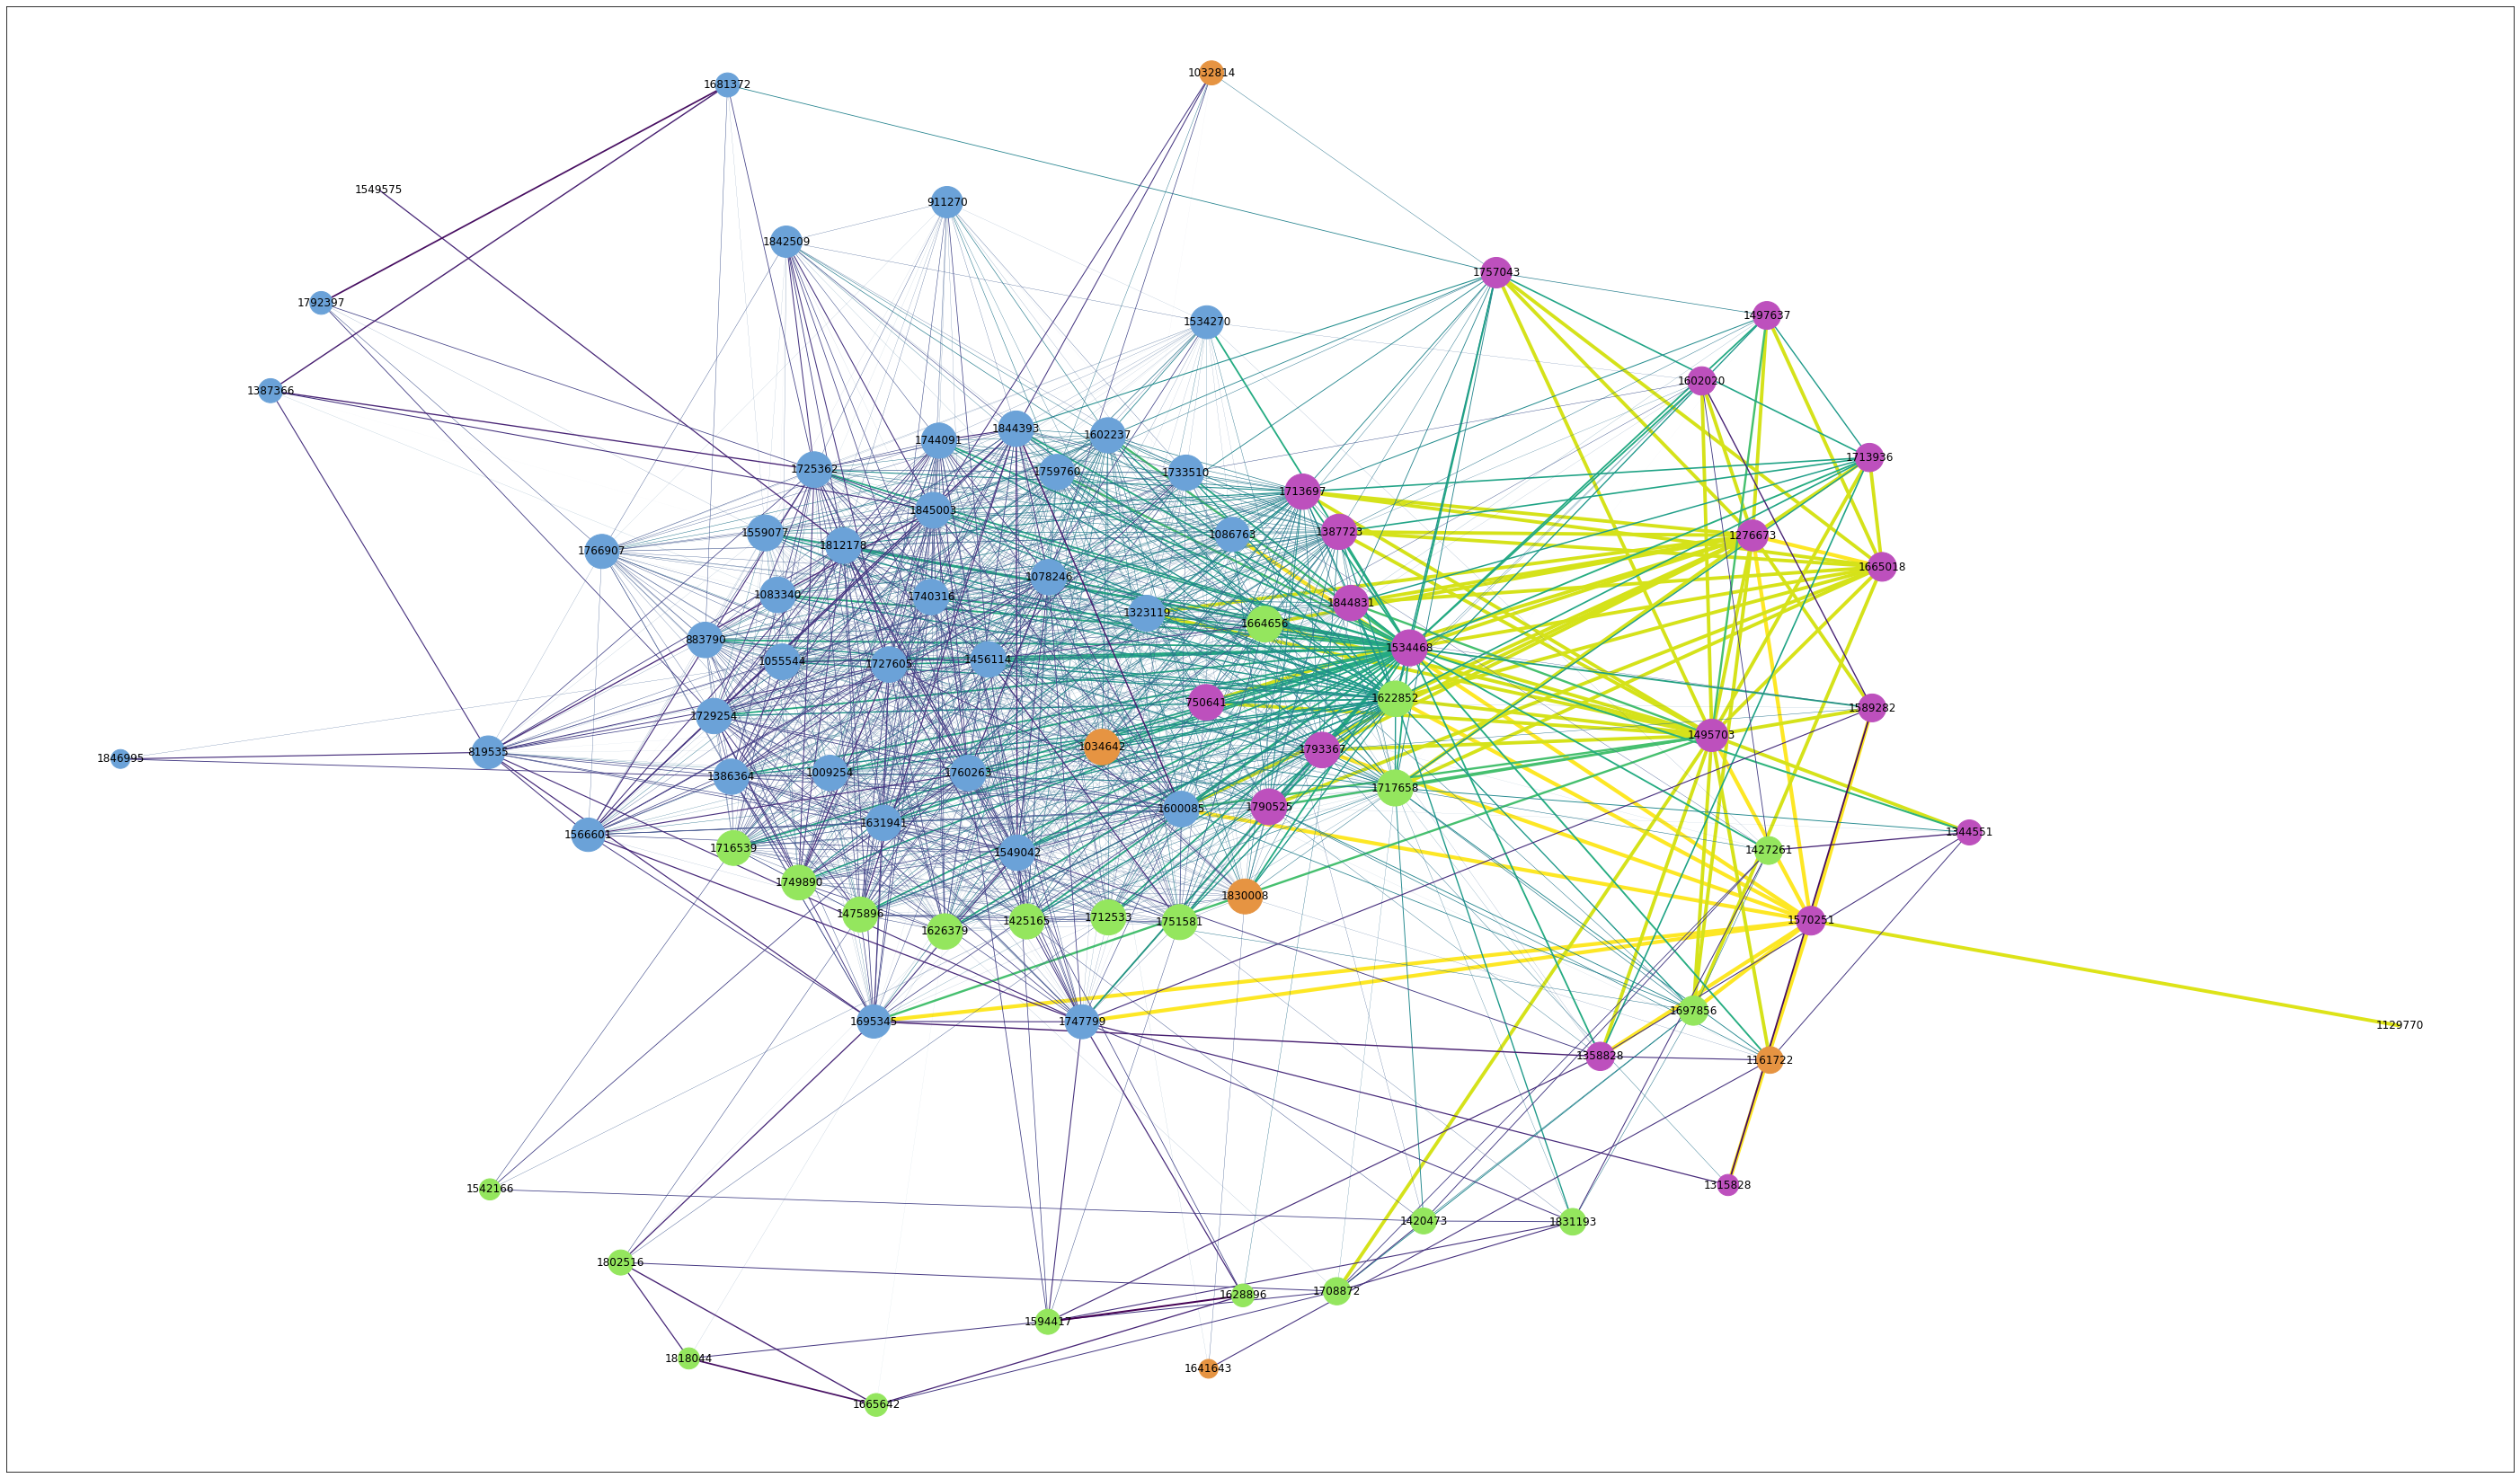

In [38]:
comm_pos = nx.kamada_kawai_layout(G)

plt.rcParams.update({'figure.figsize': (50, 30)})
# Draw external edges

nx.draw_networkx(
    G,
    pos=comm_pos,
    node_color=node_color,
    node_size=node_degree,
    width=weigth_list,
    edge_color=weigth_list)

edge weigth: the two cik volume(value)

node weigth: the degree of node(higher connection, bigger node size)